<a href="https://colab.research.google.com/github/felkira/unifact.github.io/blob/modeling/after_usability_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Record Each Cell's Execution Time
!pip install keras-tcn
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json, re, string, gdown, math, time
from tcn import TCN
from keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D, concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report as cr, precision_recall_fscore_support as prfs
from collections import Counter
from random import randint
from google.colab import files

time: 3.45 s (started: 2022-12-24 22:36:53 +00:00)


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz

--2022-12-24 22:36:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  23.1MB/s    in 53s     

2022-12-24 22:37:51 (21.9 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]

time: 54.4 s (started: 2022-12-24 22:36:57 +00:00)


In [ ]:
!gunzip cc.id.300.vec.gz

time: 30.2 s (started: 2022-12-24 22:37:51 +00:00)


In [ ]:
f = open('/content/cc.id.300.vec', encoding='utf-8')

embedding_vectors = {}
for row in f:
    values = row.split(' ')
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vectors[word] = weights

print(f"Size of vocabulary in FastText: {len(embedding_vectors)}")

Size of vocabulary in FastText: 2000000
time: 2min 26s (started: 2022-12-24 22:38:21 +00:00)


In [ ]:
url = 'https://drive.google.com/u/0/uc?id=17vCbPUY_UX-p__8QAcEWsgqZR1pLGEpf&export=download'
gdown.download(url, 'valid-7hoaks.csv', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=17vCbPUY_UX-p__8QAcEWsgqZR1pLGEpf&export=download
To: /content/valid-7hoaks.csv
100%|██████████| 3.61M/3.61M [00:00<00:00, 250MB/s]


'valid-7hoaks.csv'

time: 3.05 s (started: 2022-12-24 22:40:47 +00:00)


In [ ]:
main_data = pd.read_csv('/content/valid-7hoaks.csv')
pd.set_option('max_colwidth', 400)
main_data.head()

,kategori,judul,tanggal,narasi
0,Konten Yang Salah,video juru kamera terlihat lebih cepat dari peserta lomba lari,21/12/2022,video juru kamera cepat peserta lomba lari
1,Konten Yang Menyesatkan,pernyataan ceo pfizer saya mengundurkan diri dan vaksin mrna belum terbukti aman,20/12/2022,pernyataan ceo pfizer mengundurkan vaksin mrna terbukti aman
2,Konten Yang Salah,video perkumpulan lgbt di sicc sentul,20/12/2022,video perkumpulan lgbt sicc sentul
3,Konten Yang Menyesatkan,dijerat perkara terselubung badan pengawas pemilihan umum resmi tetapkan anies pasal berat,20/12/2022,dijerat perkara terselubung badan pengawas pemilihan resmi tetapkan anies pasal berat
4,Konten Yang Menyesatkan,ronaldo sumbang juta dolar untuk palestina buka puasa ramadan hingga jual sepatu emas,20/12/2022,ronaldo sumbang juta dolar rakyat palestina buka puasa ramadan jual sepatu emas


time: 56.9 ms (started: 2022-12-24 22:40:50 +00:00)


In [ ]:
print("Shape of data (rows, cols)=>", main_data.shape)

Shape of data (rows, cols)=> (9885, 4)
time: 986 µs (started: 2022-12-24 22:40:50 +00:00)


In [ ]:
main_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      1
dtype: int64

time: 7.75 ms (started: 2022-12-24 22:40:50 +00:00)


In [ ]:
main_data = main_data.dropna()
main_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      0
dtype: int64

time: 12.1 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
main_data.describe(include='all')

,kategori,judul,tanggal,narasi
count,9884,9884,9884,9884
unique,8,9884,1390,9880
top,Valid,video juru kamera terlihat lebih cepat dari peserta lomba lari,20/12/2022,eks danjen kopassus buzzer anies makhluk pemakan bangkai tukang fitnah adu domba
freq,4081,1,314,2


time: 23.8 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
main_data.narasi.duplicated(keep="first").value_counts()

False    9880
True        4
Name: narasi, dtype: int64

time: 4.66 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
main_data.drop_duplicates(subset="narasi", keep="first", inplace=True)
main_data.reset_index(drop=True, inplace=True)
main_data.narasi.duplicated(keep="first").value_counts()

False    9880
Name: narasi, dtype: int64

time: 12.8 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
categories = main_data.kategori.unique()
print("Categories:\n", categories)

Categories:
 ['Konten Yang Salah' 'Konten Yang Menyesatkan' 'Konten Yang Dimanipulasi'
 'Konten Palsu' 'Konten Tiruan' 'Satire/Parodi' 'Koneksi Yang Salah'
 'Valid']
time: 1.65 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
main_data.kategori.value_counts()

Valid                       4081
Konten Yang Menyesatkan     2094
Konten Yang Salah           1446
Konten Palsu                 896
Konten Yang Dimanipulasi     694
Konten Tiruan                438
Satire/Parodi                140
Koneksi Yang Salah            91
Name: kategori, dtype: int64

time: 4.75 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
main_data.loc[main_data['kategori'] == 'Konten Yang Salah', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Menyesatkan', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Dimanipulasi', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'

main_data.loc[main_data['kategori'] == 'Konten Palsu', 'kategori'] = 'Fabricated Content/Imposter Content'
main_data.loc[main_data['kategori'] == 'Konten Tiruan', 'kategori'] = 'Fabricated Content/Imposter Content'

main_data = main_data[main_data['kategori'] != 'Koneksi Yang Salah']
main_data = main_data[main_data['kategori'] != 'Satire/Parodi']

main_data.reset_index(drop=True, inplace=True)
main_data.kategori.value_counts()

Misleading Content/False Context/Manipulated Content    4234
Valid                                                   4081
Fabricated Content/Imposter Content                     1334
Name: kategori, dtype: int64

time: 16.4 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
XVal, YVal = list(main_data['narasi']), list(main_data['kategori'])

time: 1.89 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
data = main_data

time: 286 µs (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
data['words'] = [len(str(x).split()) for x in data['narasi'].tolist()]

time: 24.4 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
data[['words','narasi']].head()

,words,narasi
0,7,video juru kamera cepat peserta lomba lari
1,8,pernyataan ceo pfizer mengundurkan vaksin mrna terbukti aman
2,5,video perkumpulan lgbt sicc sentul
3,11,dijerat perkara terselubung badan pengawas pemilihan resmi tetapkan anies pasal berat
4,12,ronaldo sumbang juta dolar rakyat palestina buka puasa ramadan jual sepatu emas


time: 6.25 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
data['words'].describe()

count    9649.000000
mean       36.460048
std        33.672800
min         1.000000
25%         9.000000
50%        32.000000
75%        56.000000
max       920.000000
Name: words, dtype: float64

time: 9.62 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1334.0,29.028486,41.025516,2.0,8.0,15.0,36.0,770.0
Misleading Content/False Context/Manipulated Content,4234.0,18.754842,30.516607,1.0,7.0,10.0,18.0,920.0
Valid,4081.0,57.258270,19.726250,5.0,47.0,56.0,66.0,449.0


time: 27.8 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
# data = data[data['words']<=200]
data = data[data['words']>=3]
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1333.0,29.048762,41.034226,3.0,8.0,15.0,36.0,770.0
Misleading Content/False Context/Manipulated Content,4207.0,18.862848,30.584494,3.0,7.0,10.0,18.0,920.0
Valid,4081.0,57.258270,19.726250,5.0,47.0,56.0,66.0,449.0


time: 20.1 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
data[data['kategori']=='Valid'] = data[data['kategori']=='Valid'][:3*1333]
data[data['kategori']=='Misleading Content/False Context/Manipulated Content'] = data[data['kategori']=='Misleading Content/False Context/Manipulated Content'][1141:round(2.3*1333)+1141]

data = data.dropna()
data.reset_index(drop=True, inplace=True)
data.groupby(['kategori'])['words'].describe()

<ipython-input-24-953fb92f177b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['kategori']=='Valid'] = data[data['kategori']=='Valid'][:3*1333]
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
<ipython-input-24-953fb92f177b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1333.0,29.048762,41.034226,3.0,8.0,15.0,36.0,770.0
Misleading Content/False Context/Manipulated Content,3066.0,19.796151,33.916237,3.0,7.0,10.0,19.0,920.0
Valid,3999.0,56.740935,17.600122,10.0,47.0,55.0,66.0,449.0


time: 45 ms (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
word_freq = data['narasi'].str.split(expand=True).stack().value_counts()
word_freq = word_freq.reset_index(name='freq').rename(columns={'index': 'word'})

time: 1.49 s (started: 2022-12-24 22:40:51 +00:00)


In [ ]:
word_freq.head(10)

,word,freq
0,advertisement,3437
1,indonesia,2990
2,orang,1825
3,covid,1747
4,obat,1440
5,kesehatan,1387
6,anak,1311
7,dunia,1270
8,jakarta,1032
9,rumah,1030


time: 5.85 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
print("Number of distinct words in raw data: ", len(list(word_freq['word'])))

Number of distinct words in raw data:  29170
time: 4.2 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
max_words = len(list(word_freq['word']))
# max_words = len(list(word_freq[word_freq['freq']>=2]['word']))
max_len = int(data['words'].max())

print(max_words)
print(max_len)

29170
920
time: 4.06 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
data = data.sample(frac=1)

time: 2.76 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
X, Y = list(data['narasi']), list(data['kategori'])

encoder = LabelEncoder()
Y = to_categorical(encoder.fit_transform(Y), dtype='uint8')

print(Y.shape)
print(encoder.classes_)

(8398, 3)
['Fabricated Content/Imposter Content'
 'Misleading Content/False Context/Manipulated Content' 'Valid']
time: 9.32 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
print(np.argmax(Y, axis=1))

[1 0 1 ... 1 1 2]
time: 1.01 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
def define_report(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  precision, recall, fscore, support = prfs(y_class, y_pred_class)
  report = cr(y_class, y_pred_class, target_names = encoder.classes_)
  return fscore, report

def define_confusion(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  con_mat = cm(labels=y_class, predictions=y_pred_class).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
  con_mat_df = pd.DataFrame(con_mat_norm, index = encoder.classes_, columns = encoder.classes_)
  figure = plt.figure(figsize=(13, 10))
  sns.heatmap(con_mat_df, annot=True, fmt='.1%', cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def define_plot(name, param):
  plt.figure(figsize=(15, 7))
  plt.title(name)
  plt.plot(param.history[name], label='train')
  plt.plot(param.history[f'val_{name}'], label='test')
  plt.legend()
  plt.show();

time: 2.8 ms (started: 2022-12-24 22:40:52 +00:00)


# **Embedding Static Fasttext**

In [ ]:
emb_dim = 300
def define_embed(vocabSize, wordId):
  embedding_matrix = np.zeros((vocabSize, emb_dim))
  oov_count = 0
  oov_words = []
  for word, idx in wordId.items():
    if idx < vocabSize:
      embedding_vector = embedding_vectors.get(word)
      if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
      else:
        oov_count += 1 
        oov_words.append(word)
  return embedding_matrix

time: 928 µs (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
def define_model(kernel_size, activation, optimizer, input_dim, max_length, output_dim = 300, emb_matrix = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length,
                  # Assign the embedding weight with fasttext embedding matrix
                  weights = [emb_matrix],
                  # Set the weight to be trainable (dynamic)
                  trainable = True
                  )(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(TCN(64, kernel_size=kernel_size, dilations = [1, 2], return_sequences=True, activation = activation, name = 'tcn1'))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dropout(0.5)(conc)
    outp = Dense(Y.shape[1], activation="softmax")(conc)   

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

time: 1.56 ms (started: 2022-12-24 22:40:52 +00:00)


In [ ]:
model0_random = define_model(3, 'relu', 'adam', 300, 121, emb_matrix = np.random.rand(300, 300))
model0_random.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 121)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 121, 300)     90000       ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 121, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 121, 128)     227968      ['spatial_dropout1d[0][0]']  

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=2, mode='min', restore_best_weights=True)

time: 538 µs (started: 2022-12-24 22:40:56 +00:00)


In [ ]:
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['tanh', 'elu', 'relu', 'selu']
optimizers = ['adam', 'adamax']
kernel_sizes = [2, 4, 7, 8]

columns = ['Optimizer', 'Activation', 'Filters', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'accAVG', 'loss1', 'loss2', 'loss3', 'loss4', 'loss5', 'lossAVG']
record = pd.DataFrame(columns = columns)
kfold = KFold(n_splits=5, shuffle=True)

sentences, labels = X, Y

clouds = []
valid_selected = []
false_selected = []
imposter_selected = []
models = []
fscores = []
reports = []
metas = []
exp = 0

for optimizer in optimizers:
  for activation in activations:
    for kernel_size in kernel_sizes:
      exp+=1
      print('--------------------------------------------------------------')
      print('Training {}: {} optimizer, {} activation, {} kernel size.'.format(exp, optimizer, activation, kernel_size))
      print('--------------------------------------------------------------')
      acc_list = []
      loss_list = []
      for train, test in kfold.split(sentences):

        train_x, test_x = [], []
        train_y, test_y = [], []
        
        for i in train:
          train_x.append(sentences[i])
          train_y.append(labels[i])
        for i in test:
          test_x.append(sentences[i])
          test_y.append(labels[i])

        train_valid = []
        train_false = []
        train_imposter = []
        for i in range(len(train_y)):
          label = list(encoder.inverse_transform([np.argmax(train_y[i])]))[0]
          if label == 'Valid':
            for j in train_x[i].split(): train_valid.append(j)
          if label == 'Misleading Content/False Context/Manipulated Content':
            for j in train_x[i].split(): train_false.append(j)
          if label == 'Fabricated Content/Imposter Content':
            for j in train_x[i].split(): train_imposter.append(j)
        
        valid_res = dict(Counter(train_valid))
        false_res = dict(Counter(train_false))
        imposter_res = dict(Counter(train_imposter))
        
        valid_selected.append({k: v for k, v in sorted(valid_res.items(), key=lambda item: item[1], reverse=True)})
        false_selected.append({k: v for k, v in sorted(false_res.items(), key=lambda item: item[1], reverse=True)})
        imposter_selected.append({k: v for k, v in sorted(imposter_res.items(), key=lambda item: item[1], reverse=True)})
        
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        tokenizer = text.Tokenizer(num_words = max_words, oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)
        training_sequences = tokenizer.texts_to_sequences(train_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)
        Xtrain = sequence.pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xtest = sequence.pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

        wordIdx = tokenizer.word_index
        clouds.append(wordIdx)
        vocabSize = len(wordIdx)+1
        embedding_matrix = define_embed(vocabSize, wordIdx)

        model = define_model(kernel_size, activation, optimizer, input_dim=vocabSize, max_length=max_len, emb_matrix=embedding_matrix)
        history = model.fit(Xtrain, train_y, batch_size=50, epochs=100, verbose=0, 
                  callbacks=[callbacks], validation_data=(Xtest, test_y))
        
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print(f'Loss: {loss} - Accuracy: {acc}\n')
        result = model.predict(Xtest)
        fscore, report = define_report(result, test_y)
        metas.append([Xtest, test_y, result, history])
        reports.append(report)
        fscores.append(fscore)
        acc_list.append(acc*100)
        loss_list.append(loss)
        models.append(model)
          
      mean_acc = np.array(acc_list).mean()
      mean_loss = np.array(loss_list).mean()
      parameters = [optimizer, activation, kernel_size]
      entries = parameters + acc_list + [mean_acc] + loss_list + [mean_loss]
      temp = pd.DataFrame([entries], columns=columns)
      record = record.append(temp, ignore_index=True)
      print('\n')

In [ ]:
record

In [ ]:
record[['Activation', 'accAVG']].groupby(by='Activation').max().sort_values(by='accAVG', ascending=False)

,accAVG
Activation,
tanh,92.343422
elu,92.295678


time: 14.1 ms (started: 2022-12-25 00:33:11 +00:00)


In [ ]:
record[['Activation', 'lossAVG']].groupby(by='Activation').min().sort_values(by='lossAVG', ascending=True)

,lossAVG
Activation,
tanh,0.212583
elu,0.216271


time: 8.01 ms (started: 2022-12-25 00:33:11 +00:00)


In [ ]:
record[['Optimizer', 'accAVG']].groupby(by='Optimizer').max().sort_values(by='accAVG', ascending=False)

In [ ]:
record[['Optimizer', 'lossAVG']].groupby(by='Optimizer').min().sort_values(by='lossAVG', ascending=True)

In [ ]:
max_fscore_0 = [i[0] for i in fscores]
max_fscore_0_idx = [i for i in range(len(max_fscore_0)) if max_fscore_0[i] >= .78]
print(*max_fscore_0_idx, sep=', ')

4, 5, 12, 64, 66
time: 818 µs (started: 2022-12-25 00:33:11 +00:00)


In [ ]:
fscore_filtered = [m for m in [[i, rec[1]] for i, rec in enumerate(fscores) if i in max_fscore_0_idx] if m[1] >= .85]

print(fscore_filtered)

[[4, 0.8916055419722901], [5, 0.901360544217687], [12, 0.910086004691165], [64, 0.9059967585089141], [66, 0.9146049481245013]]
time: 1.52 ms (started: 2022-12-25 00:33:21 +00:00)


In [ ]:
for i in range(len(fscore_filtered)):
  print(reports[fscore_filtered[i][0]], '\n\n')

                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.83      0.74      0.78       288
Misleading Content/False Context/Manipulated Content       0.87      0.91      0.89       599
                                               Valid       0.99      0.99      0.99       792

                                            accuracy                           0.92      1679
                                           macro avg       0.90      0.88      0.89      1679
                                        weighted avg       0.92      0.92      0.92      1679
 


                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.86      0.76      0.81       268
Misleading Content/False Context/Manipulated Content       0.88      0.92      0.90       575
                                               Valid 

In [ ]:
bests = [i for i in range(len(fscore_filtered))]
selecteds = [fscore_filtered[i][0] for i in bests]

time: 947 µs (started: 2022-12-25 00:34:21 +00:00)


In [ ]:
print(selecteds)

[4, 5, 12, 64, 66]
time: 473 µs (started: 2022-12-25 00:34:24 +00:00)


In [ ]:
def tokenize(text, cloud):
  s = text.split()
  return [cloud[s[i]] if s[i] in cloud else 1 for i in range(len(s))]

def pad_sequence(seq):
  return [0 if i < (max_len - len(seq)) else seq[i - (max_len - len(seq))] for i in range(max_len)]

time: 1.36 ms (started: 2022-12-25 00:34:35 +00:00)


In [ ]:
results = []
falsy = []

for j in selecteds:
  predict_temp = []
  false_temp = []
  falsy_temp = []
  print(f'model-{j} predict')
  for i in range(len(XVal)):
    seq = tokenize(XVal[i], clouds[j])
    padded = np.array([pad_sequence(seq)])
    preds = models[j].predict(padded)
    proba = preds[0].tolist()
    classes = list(encoder.classes_)
    prediction = classes[proba.index(max(preds[0]))]
    if prediction == YVal[i]: predict_temp.append(True)
    else: false_temp.append(classes.index(YVal[i]))
    falsy_temp.append({YVal[i].split()[0]: prediction.split()[0]})

  results.append(f'correct: {len(predict_temp)}/{len(XVal)}: {round(len(predict_temp)/len(XVal) * 100, 3)}%  -  false-i: {false_temp.count(0)}  -  false-m: {false_temp.count(1)}  -  false-v: {false_temp.count(2)}')
  falsy.append(falsy_temp)

In [ ]:
for i in range(len(selecteds)):
  print('model:', selecteds[i], f'\n{results[i]}')

# 9377, 9046, 9102, 8856, 8875, 9208, 8859, 9280, 8579, 9102, 9148

model: 4 
correct: 9267/9649: 96.041%  -  false-i: 143  -  false-m: 225  -  false-v: 14
model: 5 
correct: 9245/9649: 95.813%  -  false-i: 212  -  false-m: 180  -  false-v: 12
model: 12 
correct: 8484/9649: 87.926%  -  false-i: 253  -  false-m: 900  -  false-v: 12
model: 64 
correct: 9245/9649: 95.813%  -  false-i: 233  -  false-m: 117  -  false-v: 54
model: 66 
correct: 9205/9649: 95.398%  -  false-i: 196  -  false-m: 244  -  false-v: 4
time: 1.6 ms (started: 2022-12-25 01:17:06 +00:00)


In [ ]:
for j in range(len(selecteds)):
  i_as_v = 0
  m_as_v = 0
  v_as_h = 0
  for i in range(len(falsy[j])):
      if list(falsy[j][i].keys()) == ["Fabricated"] and list(falsy[j][i].values()) == ["Valid"]: i_as_v += 1
      if list(falsy[j][i].keys()) == ["Misleading"] and list(falsy[j][i].values()) == ["Valid"]: m_as_v += 1
      if list(falsy[j][i].keys()) == ["Valid"] and list(falsy[j][i].values()) != ["Valid"]: v_as_h += 1

  print(f'model-{selecteds[j]}')
  print(f'imposter as valid: {i_as_v}\nmisleading as valid: {m_as_v}\nvalid as hoaks: {v_as_h}')
  print('\n')

model-4
imposter as valid: 3
misleading as valid: 31
valid as hoaks: 14


model-5
imposter as valid: 5
misleading as valid: 63
valid as hoaks: 12


model-12
imposter as valid: 48
misleading as valid: 552
valid as hoaks: 12


model-64
imposter as valid: 5
misleading as valid: 26
valid as hoaks: 54


model-66
imposter as valid: 13
misleading as valid: 87
valid as hoaks: 4


time: 100 ms (started: 2022-12-25 01:17:06 +00:00)


In [ ]:
best_model = [{'index': 4, 'score': 9267}, {'index': 5, 'score': 9245}, {'index': 64, 'score': 9245}, {'index': 66, 'score': 9205}]

time: 838 µs (started: 2022-12-25 01:21:05 +00:00)


In [ ]:
best_index = [best_model[k]['index'] for k in range(len(best_model))]

time: 658 µs (started: 2022-12-25 01:21:06 +00:00)


In [ ]:
for i in range(len(selecteds)):
  if selecteds[i] in best_index:
    print('model:', selecteds[i], f'\n{results[i]}')

model: 4 
correct: 9267/9649: 96.041%  -  false-i: 143  -  false-m: 225  -  false-v: 14
model: 5 
correct: 9245/9649: 95.813%  -  false-i: 212  -  false-m: 180  -  false-v: 12
model: 64 
correct: 9245/9649: 95.813%  -  false-i: 233  -  false-m: 117  -  false-v: 54
model: 66 
correct: 9205/9649: 95.398%  -  false-i: 196  -  false-m: 244  -  false-v: 4
time: 992 µs (started: 2022-12-25 01:21:06 +00:00)


In [ ]:
for j in range(len(selecteds)):
  if selecteds[j] in best_index:
    i_as_v = 0
    m_as_v = 0
    v_as_h = 0
    for i in range(len(falsy[j])):
        if list(falsy[j][i].keys()) == ["Fabricated"] and list(falsy[j][i].values()) == ["Valid"]: i_as_v += 1
        if list(falsy[j][i].keys()) == ["Misleading"] and list(falsy[j][i].values()) == ["Valid"]: m_as_v += 1
        if list(falsy[j][i].keys()) == ["Valid"] and list(falsy[j][i].values()) != ["Valid"]: v_as_h += 1

    print(f'model-{selecteds[j]}')
    print(f'imposter as valid: {i_as_v}\nmisleading as valid: {m_as_v}\nvalid as hoaks: {v_as_h}')
    print('\n')

model-4
imposter as valid: 3
misleading as valid: 31
valid as hoaks: 14


model-5
imposter as valid: 5
misleading as valid: 63
valid as hoaks: 12


model-64
imposter as valid: 5
misleading as valid: 26
valid as hoaks: 54


model-66
imposter as valid: 13
misleading as valid: 87
valid as hoaks: 4


time: 77.5 ms (started: 2022-12-25 01:21:06 +00:00)


In [ ]:
for i in range(len(best_index)):
  print(f'model-{best_index[i]}\n')
  print(reports[best_index[i]], '\n\n')

model-4

                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.83      0.74      0.78       288
Misleading Content/False Context/Manipulated Content       0.87      0.91      0.89       599
                                               Valid       0.99      0.99      0.99       792

                                            accuracy                           0.92      1679
                                           macro avg       0.90      0.88      0.89      1679
                                        weighted avg       0.92      0.92      0.92      1679
 


model-5

                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.86      0.76      0.81       268
Misleading Content/False Context/Manipulated Content       0.88      0.92      0.90       575
                                   

In [ ]:
valid_data = pd.read_csv('/content/valid.csv')
valid_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      1
dtype: int64

time: 31.4 ms (started: 2022-12-25 01:21:21 +00:00)


In [ ]:
valid_data = valid_data.dropna()
valid_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      0
dtype: int64

time: 9.06 ms (started: 2022-12-25 01:21:22 +00:00)


In [ ]:
XValid = list(valid_data['narasi'])

time: 1.15 ms (started: 2022-12-25 01:21:22 +00:00)


In [ ]:
false_count = []

for j in best_index:
  false_temp = []
  print(f'model-{j} predict')
  for i in range(len(XValid)):
    seq = tokenize(XValid[i], clouds[j])
    padded = np.array([pad_sequence(seq)])
    preds = models[j].predict(padded)
    proba = preds[0].tolist()
    classes = list(encoder.classes_)
    prediction = classes[proba.index(max(preds[0]))]
    if prediction != 'Valid': false_temp.append(False)

  false_count.append(f'false: {len(false_temp)}/{len(XValid)}: {round(len(false_temp)/len(XValid) * 100, 3)}%')

In [ ]:
for i in range(len(best_index)):
  print('model:', best_index[i], f'\n{false_count[i]}')

model: 4 
false: 543/4428: 12.263%
model: 5 
false: 202/4428: 4.562%
model: 64 
false: 893/4428: 20.167%
model: 66 
false: 239/4428: 5.397%
time: 1.66 ms (started: 2022-12-25 01:37:06 +00:00)


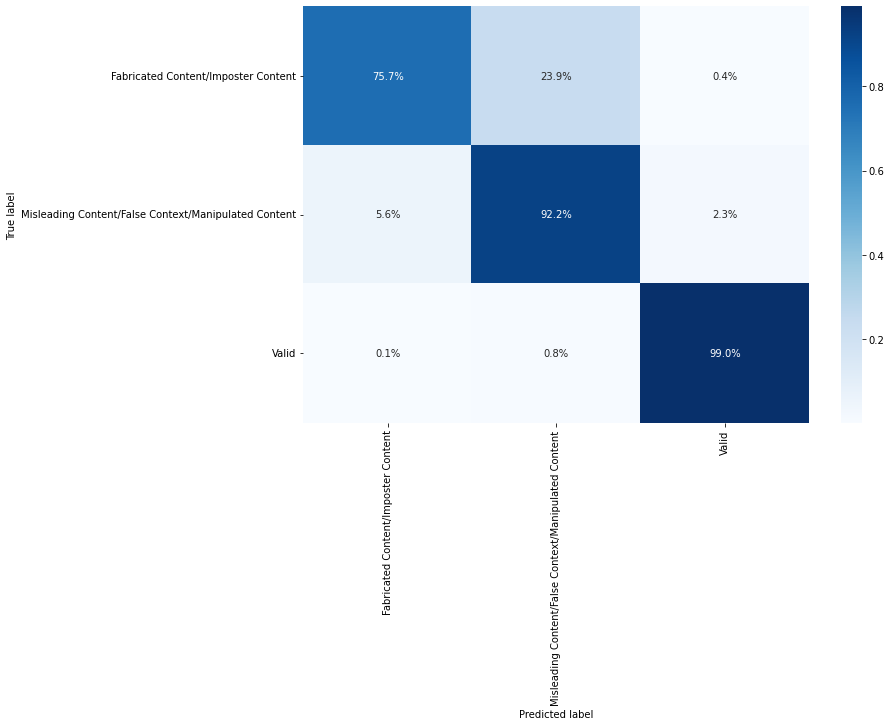

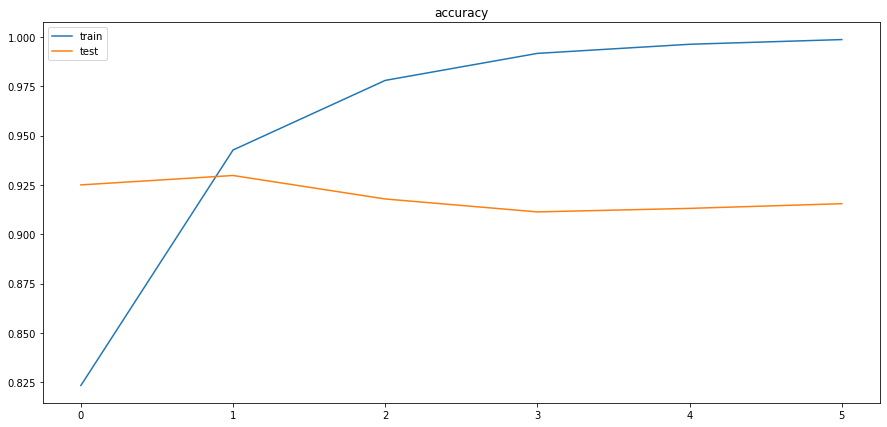

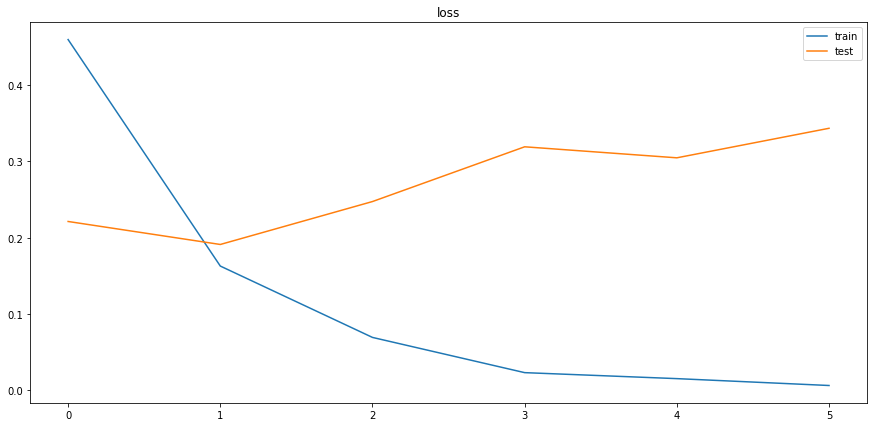




time: 675 ms (started: 2022-12-25 01:41:16 +00:00)


In [ ]:
best = [best_model[1]['index'], best_model[1]['score']]
define_confusion(metas[best[0]][2], metas[best[0]][1])
print('\n')
define_plot('accuracy', metas[best[0]][3])
print('\n')
define_plot('loss', metas[best[0]][3])
print('\n\n')

In [ ]:
record.to_excel('acc_loss_records.xlsx', index=False, encoding='utf-8')

time: 210 ms (started: 2022-12-25 01:42:54 +00:00)


In [ ]:
def cr_to_excel(report, index, score):
    report_data = []
    lines = report.split('\n')
    for line in (lines[2:5]+lines[7:9]):
        row = {}
        row_data = line.split()
        row['class'] = ' '.join(row_data[0:-4])
        row['precision'] = row_data[-4]
        row['recall'] = row_data[-3]
        row['f1_score'] = row_data[-2]
        row['support'] = row_data[-1]
        row['accuracy'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'acc{(index%5) + 1}'], 2)
        row['loss'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'loss{(index%5) + 1}'], 4)
        row['activation'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Activation']
        row['optimizer'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Optimizer']
        row['kernel'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Filters']
        row['test_score'] = round(((score-3354)/(7315-3354)*100), 2)
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_excel(f'classification_report-{index}.xlsx', index = False)

scr = [best_model[k]['score'] for k in range(len(best_model))]
for i in range(len(best_model)):
  cr_to_excel(reports[best_index[i]], best_index[i], scr[i])

for i in best_index:
  files.download(f'classification_report-{i}.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 73.7 ms (started: 2022-12-25 01:46:29 +00:00)


In [ ]:
def clouds_to_json(index):
  with open(f'word_dict-{index}.json' , 'w') as file:    
    json.dump(clouds[index], file)

clouds_to_json(best[0])

time: 35.2 ms (started: 2022-12-25 01:46:54 +00:00)


In [ ]:
def res_to_json(index):
  with open(f'residu-{index}.json' , 'w') as file:    
    json.dump({'valid': valid_selected[index], 'false': false_selected[index], 'imposter': imposter_selected[index]}, file)

res_to_json(best[0])

time: 45.1 ms (started: 2022-12-25 01:47:04 +00:00)


In [ ]:
models[best[0]].save(f"model-{best[0]}.h5")

time: 209 ms (started: 2022-12-25 01:47:13 +00:00)


In [ ]:
files.download('acc_loss_records.xlsx')

# files.download(f'classification_report-{best[0]}.xlsx')
files.download(f'word_dict-{best[0]}.json')
files.download(f'residu-{best[0]}.json')
files.download(f'model-{best[0]}.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 19.3 ms (started: 2022-12-25 01:47:19 +00:00)
